In [ ]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.util import testData
import src.model.reserve_market_functionality as rmf
import src.model.power_market_functionality as pmf

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#8cb369', '#38574d', '#5c5c5c', '#efd657', '#bc4b51'])

In [2]:
df = testData().loc["2019-03-12":"2019-03-13"]

# Create Network

In [3]:
components = pypsa.components.components.copy()

component_attrs = dict({k: v.copy() for k, v in pypsa.components.component_attrs.items()})
rmf.add_reserve_to_component_attrs(component_attrs)
rmf.add_reserve_market_to_component_attrs(components, component_attrs)
pmf.add_power_market_to_component_attrs(component_attrs)

In [4]:
def createGeneratorAndBESSNetwork(n):
    n.add("Bus","bus1")
    n.add("Bus","bus2")
    n.add("Bus","busb")
    n.add("Generator","gen1",bus="bus1",p_nom=100, marginal_cost=10, reserve_pos_max=100, reserve_neg_max=100)

    eta=0.9797
    n.add("Link","eleccharge", bus0 = "bus1", bus1 = "busb", p_nom = 6, efficiency = eta)
    n.add("Link","elecdischarge", bus0 = "busb", bus1 = "bus1", p_nom = 6, efficiency = eta)
    n.add("StorageUnit","bat", bus="busb", state_of_charge_initial=10,p_nom=20,standing_loss = 0,p_min_pu=-1,reserve_pos_max=20, reserve_neg_max=20)

    n.add("Generator","da",bus="bus2",marginal_cost=df["da_EUR_MWh"],is_market=True, include_bids=True, p_min_pu=-1,p_nom=np.inf)
    n.add("aFRR_Market","aFRR",marginal_cost_pos=df["aFRR_pos_EUR_MW"],marginal_cost_neg=df["aFRR_neg_EUR_MW"],include_bids=True)

    n.add("Link","link1",bus0="bus1",bus1="bus2",p_nom=1000)

In [5]:
snapshots = df.index
n = pypsa.Network(snapshots=snapshots,override_components=components,override_component_attrs=component_attrs)
createGeneratorAndBESSNetwork(n)

In [6]:
def extra_functionality(n: pypsa.Network, sn):
    rmf.add_reserve_market_to_model(n)
    pmf.add_power_market_to_model(n)

# Run Optimization

In [7]:
n.optimize(extra_functionality=extra_functionality)

Index(['bus1', 'bus2', 'busb'], dtype='object', name='Bus')
Index(['eleccharge', 'elecdischarge', 'link1'], dtype='object', name='Link')
Index(['bus1', 'bus2', 'busb'], dtype='object', name='Bus')
Index(['eleccharge', 'elecdischarge', 'link1'], dtype='object', name='Link')
/home/tom/Dokumente/Uni/HIWI/PyPSA-stochUC/.env/lib/python3.10/site-packages/linopy/common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.18s
INFO:linopy.solvers:Log file at /tmp/highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2256 primals, 1898 duals
Objective: -1.65e+05
Solver model: available
Solver message: optimal



Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e-02, 8e+01]
  Bound  [2e+01, 1e+02]
  RHS    [6e+00, 1e+03]
Presolving model
622 rows, 576 cols, 1726 nonzeros  0s
499 rows, 453 cols, 1819 nonzeros  0s
478 rows, 407 cols, 1721 nonzeros  0s
Presolve : Reductions: rows 478(-1420); columns 407(-1849); elements 1721(-2598)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.4260088792e-09 Ph1: 285(284858); Du: 0(3.54808e-11) 0s
        302    -1.6492080577e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 302
Objective value     : -1.6492080577e+05
HiGHS run time      :          0.02
Writing the solution to /tmp/linopy-solve-dzl5ac3j.sol


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, aFRR-bid_capacity_constraint_pos, aFRR-bid_capacity_constraint_neg, aFRR-bid_capacity_constraint_4h_blocks, DayAhead-bid_capacity_constraint were not assigned to the network.


('ok', 'optimal')

# Plot Results
## Power of Generators and Storage Units

Text(0, 0.5, 'Power [MW]')

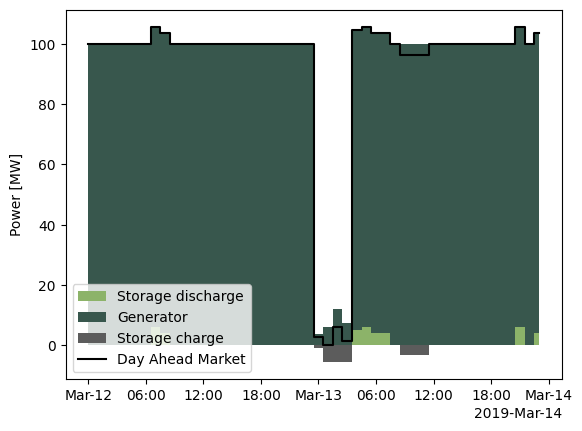

In [75]:
from matplotlib.dates import ConciseDateFormatter, AutoDateLocator

p_gen = n.generators_t.p["gen1"]
p_stu = n.storage_units_t.p["bat"]
p_market = -n.generators_t.p["da"]

# split the storage unit power into charging and discharging
p_stu_charge = p_stu.clip(upper=0)
p_stu_discharge = p_stu.clip(lower=0)

p_stacked = pd.concat([p_stu_discharge,p_gen], axis=1, keys=["Storage discharge","Generator"])
fig, ax = plt.subplots()
ax.stackplot(snapshots, p_stacked.T, labels=p_stacked.columns, step="mid")
ax.stackplot(snapshots, p_stu_charge.T, labels=["Storage charge"], step="mid")
ax.step(snapshots, p_market, label="Day Ahead Market", color="black", where="mid")

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))

ax.legend()
ax.set_ylabel("Power [MW]")

## Reserved Power

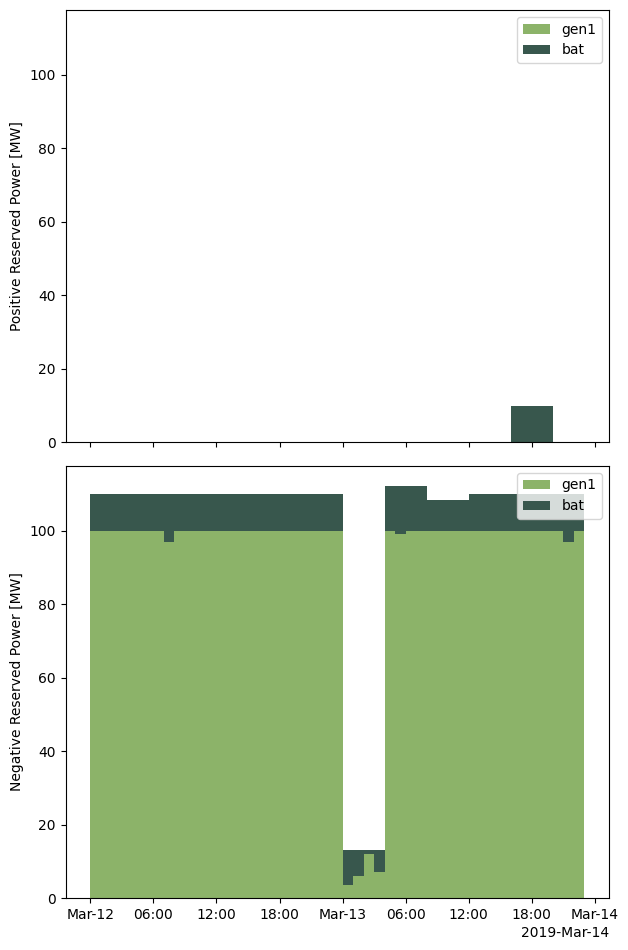

In [74]:
# index of Generators that are no power market
gen_idx = n.generators.index[~n.generators.is_market]
reserve_pos_gen = n.generators_t.reserve_pos[gen_idx]
reserve_neg_gen = n.generators_t.reserve_neg[gen_idx]
reserve_pos_stu = n.storage_units_t.reserve_pos
reserve_neg_stu = n.storage_units_t.reserve_neg

# concat the reserve power of generators and storage units
reserve_pos = pd.concat([reserve_pos_gen, reserve_pos_stu], axis=1)
reserve_neg = pd.concat([reserve_neg_gen, reserve_neg_stu], axis=1)

fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(6.4, 9.6))
axs[0].stackplot(snapshots, reserve_pos.T, labels=reserve_pos.columns, step="post")
axs[1].stackplot(snapshots, reserve_neg.T, labels=reserve_neg.columns, step="post")

for ax in axs:
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
    ax.legend()

axs[0].set_ylabel("Positive Reserved Power [MW]")
axs[1].set_ylabel("Negative Reserved Power [MW]")

fig.tight_layout()

## Market Bids

Text(0, 0.5, 'negative aFRR Price [EUR/MW]')

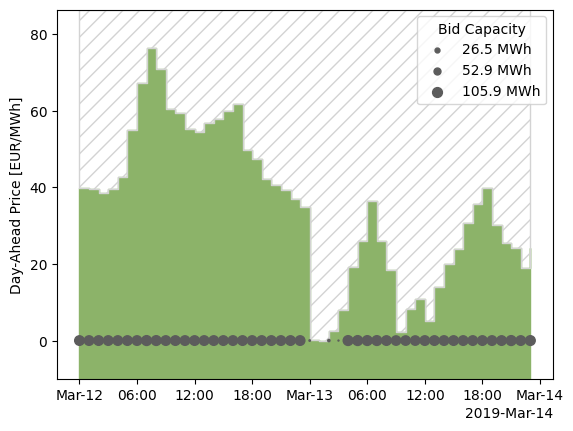

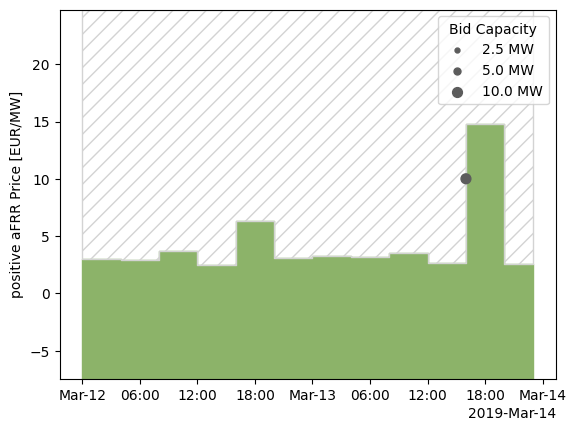

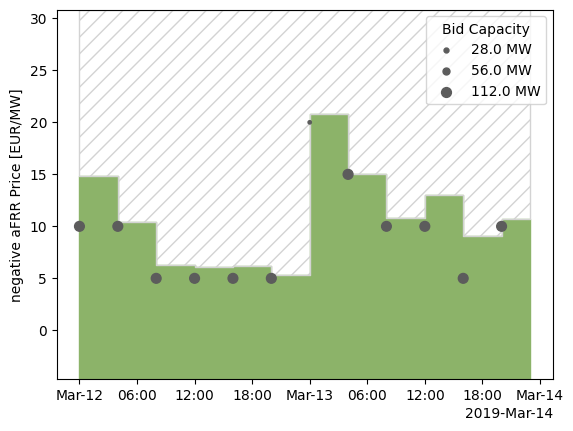

In [70]:
def plotBids(bids, marginal_price, bid_unit="MW"):
    fig, ax = plt.subplots()
    lim = marginal_price.min()-10, marginal_price.max()+10
    ax.set_ylim(lim)

    ax.fill_between(snapshots, lim[0], marginal_price, color='C0', step="post")
    ax.fill_between(snapshots, marginal_price, lim[1], color='none', step="post", hatch="//", edgecolor='lightgray')

    price_levels = bids.columns
    for price_level in price_levels:
        x = bids.index
        y = price_level*np.ones(x.shape)
        s = bids[price_level]/bids.max().max()*50
        ax.scatter(x, y, s=s, color='C2')    

    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))

    # add legend for marker size. Legend for 1.0, 0.5 and 0.25 times the maximum bid capacity
    handles, labels = ax.get_legend_handles_labels()
    max_bid = bids.max().max()
    for size in [0.25, 0.5, 1.0]:
        handles.append(ax.scatter([], [], s=size*50, color='C2'))
        labels.append(f'{size*max_bid:.1f} {bid_unit}')
    ax.legend(handles, labels, title="Bid Capacity", loc="upper right")

    return ax

ax = plotBids(pmf.get_da_bids(n), df["da_EUR_MWh"], bid_unit="MWh")
ax.set_ylabel("Day-Ahead Price [EUR/MWh]")

ax = plotBids(rmf.get_aFRR_bids(n)["pos"], df["aFRR_pos_EUR_MW"])
ax.set_ylabel("positive aFRR Price [EUR/MW]")

ax = plotBids(rmf.get_aFRR_bids(n)["neg"], df["aFRR_neg_EUR_MW"])
ax.set_ylabel("negative aFRR Price [EUR/MW]")

## Comparison Power Transfer to Day Ahead Market and Market Price

Text(0, 0.5, 'Day-Ahead Price [EUR/MWh]')

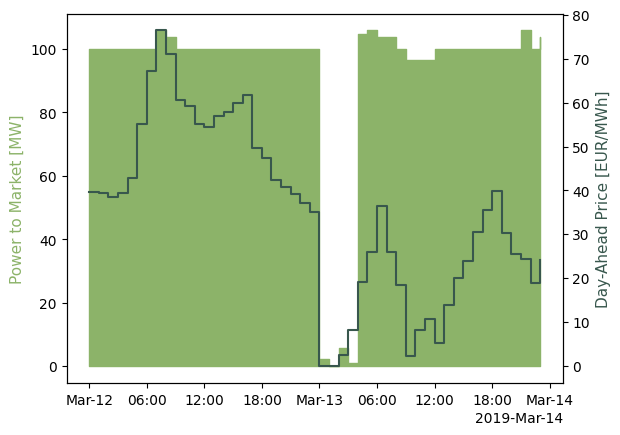

In [68]:
marginal_price = n.generators_t.marginal_cost["da"]
p_market = -n.generators_t.p["da"]
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.fill_between(snapshots, p_market, color='C5', step="post")
ax2.step(snapshots, marginal_price, color='C1', where="post")
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
ax.set_ylabel("Power to Market [MW]", color='C5', fontsize=11)
ax2.set_ylabel("Day-Ahead Price [EUR/MWh]", color='C1', fontsize=11)

## State of Charge of the Storage

Text(0, 0.5, 'Battery State of Charge [MWh]')

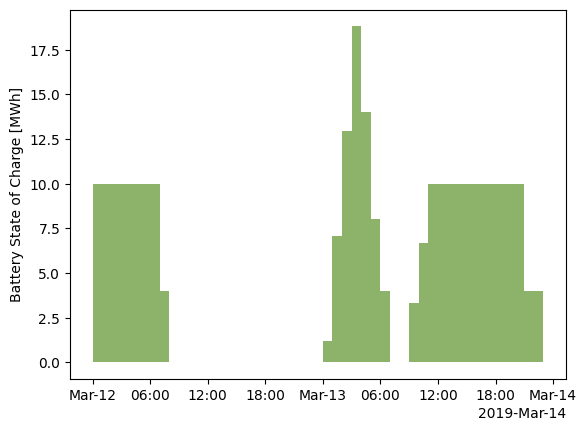

In [47]:
soc = n.storage_units_t.state_of_charge["bat"]
fig, ax = plt.subplots()
ax.fill_between(snapshots, soc, step="post")
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
ax.set_ylabel("Battery State of Charge [MWh]")